# Customer Churn Prediction for a Bank

## Abstract

Customer churn refers to the problem where customers stop all their associations with a certain organization. This phoenomenon is often observed in the Banking sector where customers close their banking accounts or stop enrolling into services offered by a bank. In this notebook we use the customer details from ABC bank and understand the significant factors associated with the customer churn and build a binary classification model to help predict whether a customer is likely to churn. The dataset contains 11 independent variables. The target variable/dependent variable is the churn variable, which indicates whether the customer would churn or not. In this experiment we are using a linear model (Logistic Regression), a tree based model(Decision Tree) and H2O autoML framework to train and test various models and select the best model that would help us best classify the data. To understand the significance of features we use SHAP analysis, Partial Dependence Plots and Individual Conditional expectation plots to understand the influence of each feature on the prediction. It is found that the Gradient Boosting model was the best performer with accuracy of ~86% in the automl leaderboard. From the analysis, it is found that age is the most significant feature to identify if a customer is likely to churn, that is common across all algorithms. active_member and products_number features are next most significant features, that could significantly impact the decision making capabilities of a model.

## Objective

In this notebook, we use the H2O AutoML framework to perform Binary Classification on the Bank Customer Churn prediction dataset.

* What are the data types? (Only numeric and categorical)

* Are there missing values?

* What are the likely distributions of the numeric variables?

* Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

* Which independent variables have missing data? How much?

* Do the training and test sets have the same data?

* In the predictor variables independent of all the other predictor variables?

* Which predictor variables are the most important?

* Do the ranges of the predictor variables make sense?

* What are the distributions of the predictor variables?   

* Remove outliers and keep outliers (does if have an effect of the final predictive model)?

* Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?  That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error.For categorical data, calculate the accuracy and a confusion matrix.
    
* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

* Fit a linear model and interpret the regression coefficients

* Fit a tree-based model and interpret the nodes

* Use auto ml to find the best model

* Run SHAP analysis on the models, interpret the SHAP values and compare them with the other model interpretability methods.

### Dataset

This dataset has 10000 records and 12 columns(11 features and a target variable(Churn) containing details of customers for ABC Multistate bank.

* customer_id - unique id representing each customer
* credit_score - credit score for each customer
* country - location of the account
* gender - customer gender
* age - age of customer
* tenure -  duration with the bank for each customer
* balance - account balance
* products_number -  number of bank products utilized by the customer
* credit_card - no of credit cards held by customer
* active_member - 0 or 1, does the customer regularly use the services offered by the bank
* estimated_salary -  salary of customer
* churn - target variable. 1 if the client has left the bank during some period or 0 if he/she has not.


In [1]:
! pip install -q kaggle
! pip install h2o
! pip install shap

In [2]:
from google.colab import files

In [3]:
# files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"akshaybharadwaj","key":"78ef417f09742e18e2754849a94ee3f6"}'}

In [4]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download gauravtopre/bank-customer-churn-dataset

bank-customer-churn-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip bank-customer-churn-dataset.zip

Archive:  bank-customer-churn-dataset.zip
replace Bank Customer Churn Prediction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
import h2o
from h2o.automl import H2OAutoML
import scipy.stats as stats
from scipy.stats import chi2_contingency
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator
import shap
import graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import PartialDependenceDisplay
# Initialize H2O cluster
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 42 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_akshaybharadwaj_kuird8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.981 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
# !pip install h2o

## Exploratory Data Analysis

In [3]:
# Load the data

df_churn_original = pd.read_csv("Bank Customer Churn Prediction.csv")

In [4]:
# Check the dimensions of the Data
print("No of Rows : {} \nNo of Columns : {}".format(df_churn_original.shape[0], df_churn_original.shape[1]))

No of Rows : 10000 
No of Columns : 12


In [5]:
# Display the dataframe

df_churn_original

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [6]:
df_churn_original['churn'] = pd.Categorical(df_churn_original['churn'])
df_churn_original = df_churn_original.drop('customer_id', axis=1)
df_churn_original['active_member'] = pd.Categorical(df_churn_original['active_member'])

### Q1. What are the data types? (Only numeric and categorical)

In [7]:
# get the datatypes of columns
df_churn_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  object  
 2   gender            10000 non-null  object  
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  int64   
 7   credit_card       10000 non-null  int64   
 8   active_member     10000 non-null  category
 9   estimated_salary  10000 non-null  float64 
 10  churn             10000 non-null  category
dtypes: category(2), float64(2), int64(5), object(2)
memory usage: 723.0+ KB


In [8]:
# List of numeric variables in the data
numeric_columns = df_churn_original.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_columns

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'estimated_salary']

In [9]:
# removing unique customer id from column
numeric_columns.pop(0)
# numeric_columns

'credit_score'

In [10]:
numeric_columns

['age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'estimated_salary']

In [11]:
cat_cols = df_churn_original.select_dtypes(include=['category','object']).columns.tolist()
cat_cols.pop()
cat_cols

['country', 'gender', 'active_member']

In [12]:
# Check for duplicates within the data
df_churn_original = df_churn_original.drop_duplicates()
print("No of Rows : {} \nNo of Columns : {}".format(df_churn_original.shape[0], df_churn_original.shape[1]))
print("No duplicates present in the data")

No of Rows : 10000 
No of Columns : 11
No duplicates present in the data


#### Do the ranges of the predictor variables make sense?



In [13]:
# Get the summary metrics for numerical variables
df_churn_original.describe()

,credit_score,age,tenure,balance,products_number,credit_card,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,199992.480000


The numbers above makes sense. For example:
* credit score is between 350 and 850
* age is between 18 to 92
* tenure is 0(new customer) to 10 years(loyal customer)
* credit card no 0 or 1

These numbers are close to real world numbers

### Q2. Are there missing values?

In [14]:
# Identify missing values in the data across all variables

df_churn_original.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

### Distribution of Variables - Univariate Plots

#### What are the distributions of the predictor variables?


In [15]:
# Function to plot distributions (Density plot and Box Plot)

def Dist_Plot(df, column, title, xLabel, yLabel, mul_factor, amount_limit):
    # Create a facetgrid of 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [.70, .30]})

    # Density plot
    bins_var = [0]
    for i in range(1,amount_limit):
        bins_var.append(i*mul_factor)

#     print(bins_var)
    amt_plot = sns.histplot(data=df, x=column, ax=ax[0], bins=bins_var)
    ax[0].axvline(df[column].mean(), color='r', linestyle='--')
    amt_plot.set_xlabel(xLabel)
    amt_plot.set_ylabel(yLabel)
    amt_plot.set_title(title)

    # Box Plot
    amt_box = sns.boxplot(y=column, data=df, ax=ax[1])
#     amt_box.set_ylabel(yLabel)
    # amt_box.set_title("Distribution of Transaction Amount")
    plt.show()

    # Get the outlier percentage for the independent variable
    outliers = boxplot_stats(df[column])[0]['fliers']
    print("Percentage of Oultliers based on Inter Quartile Range {}%".format((len(outliers)/df.shape[0])*100))





#### Distribution of Country

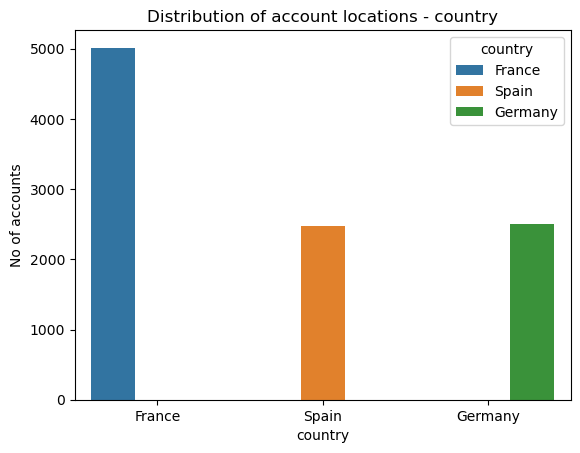

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

 France has the highest number of customer accounts contributing to 50% of the data


In [16]:
val_counts = pd.value_counts(df_churn_original.country)
type_count = sns.countplot(data=df_churn_original, x="country", hue="country")
type_count.set_title("Distribution of account locations - country")
type_count.set_ylabel("No of accounts")
plt.show()
print(val_counts)
print("\n France has the highest number of customer accounts contributing to {}% of the data".format(round(((val_counts[0])/df_churn_original.shape[0])*100)))

#### Distribution of Gender

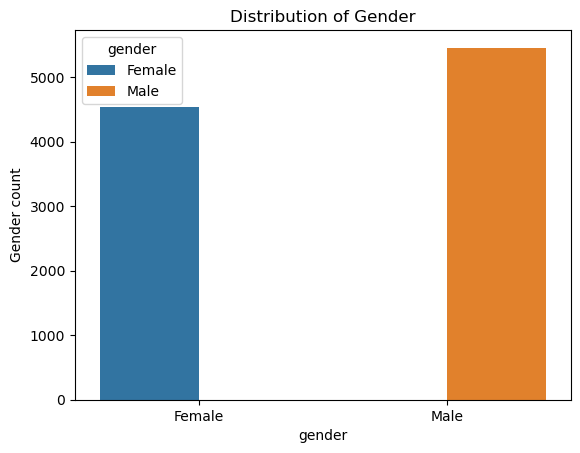

Male      5457
Female    4543
Name: gender, dtype: int64

 The number of accounts held by male customers is greater than female cusotmers contributing to 55% of the data


In [17]:
val_counts = pd.value_counts(df_churn_original.gender)
type_count = sns.countplot(data=df_churn_original, x="gender", hue="gender")
type_count.set_title("Distribution of Gender")
type_count.set_ylabel("Gender count")
plt.show()
print(val_counts)
print("\n The number of accounts held by male customers is greater than female cusotmers contributing to {}% of the data".format(round(((val_counts[0])/df_churn_original.shape[0])*100)))

#### Distribution of  Active_customer

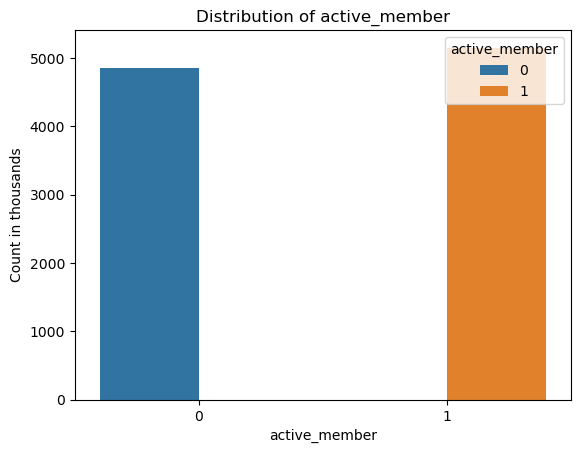

1    5151
0    4849
Name: active_member, dtype: int64


In [18]:
val_counts = pd.value_counts(df_churn_original.active_member)
type_count = sns.countplot(data=df_churn_original, x="active_member", hue="active_member")
type_count.set_title("Distribution of active_member")
type_count.set_ylabel("Count in thousands")
plt.show()
print(val_counts)

 #### What are the likely distributions of the numeric variables?

#### Distribution of Credit Score

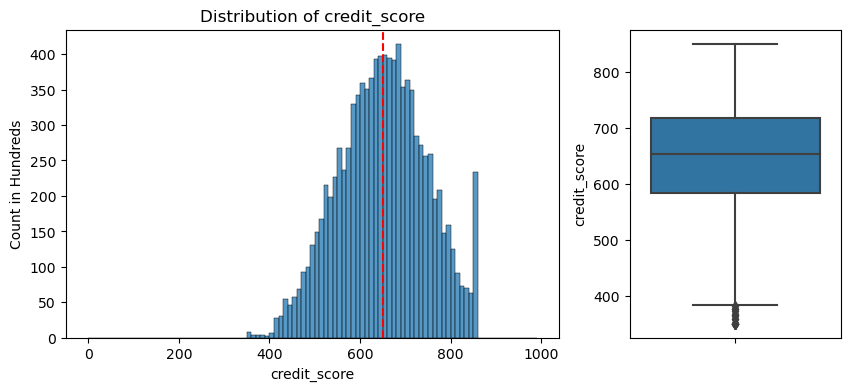

Percentage of Oultliers based on Inter Quartile Range 0.15%


In [19]:
Dist_Plot(df_churn_original,'credit_score',"Distribution of " + 'credit_score', 'credit_score', "Count in Hundreds", 10, 100)
print("===============================================================")

#### Distribution of Age

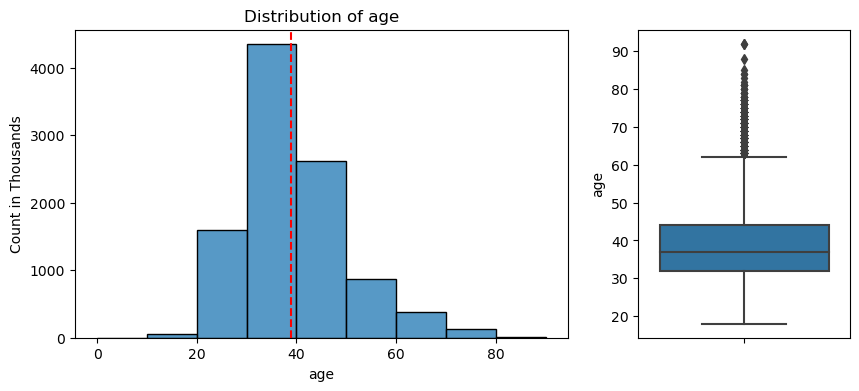

Percentage of Oultliers based on Inter Quartile Range 3.5900000000000003%


In [20]:
Dist_Plot(df_churn_original,'age',"Distribution of " + 'age', 'age', "Count in Thousands", 10, 10)
print("===============================================================")

#### Distribution of tenure

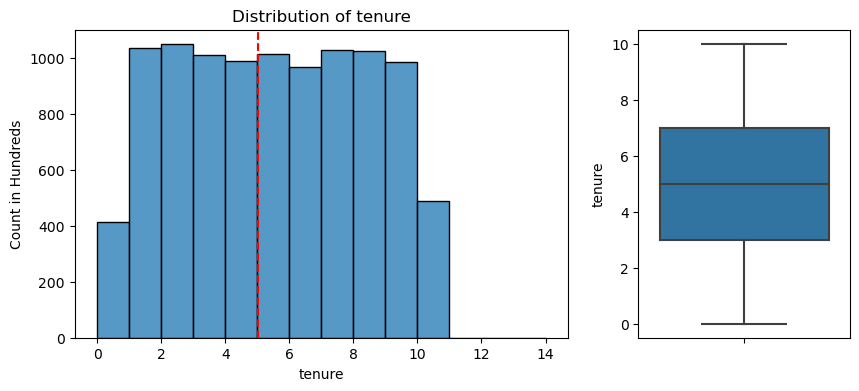

Percentage of Oultliers based on Inter Quartile Range 0.0%


In [21]:
Dist_Plot(df_churn_original,'tenure',"Distribution of " + 'tenure', 'tenure', "Count in Hundreds", 1, 15)
print("===============================================================")

#### Distribution of Account Balance

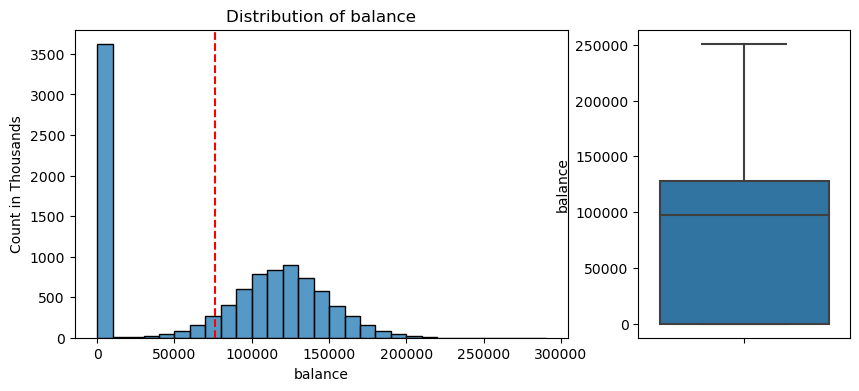

Percentage of Oultliers based on Inter Quartile Range 0.0%


In [22]:
Dist_Plot(df_churn_original,'balance',"Distribution of " + 'balance', 'balance', "Count in Thousands", 10000, 30)
print("===============================================================")

#### Distribution of No of Bank Products used by Customer

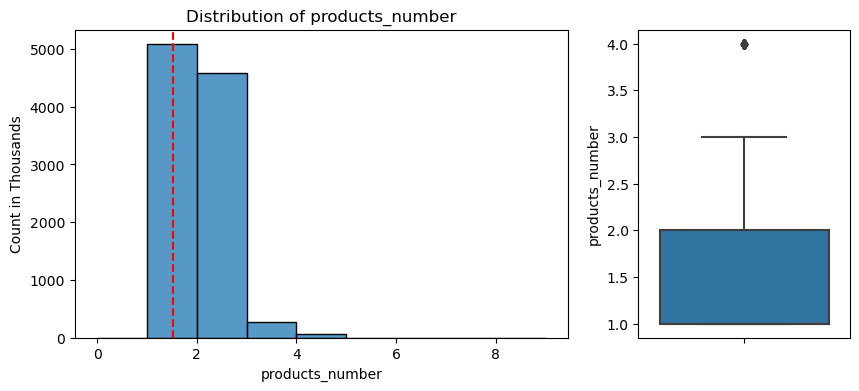

Percentage of Oultliers based on Inter Quartile Range 0.6%


In [23]:
Dist_Plot(df_churn_original,'products_number',"Distribution of " + 'products_number', 'products_number', "Count in Thousands", 1, 10)
print("===============================================================")

#### Distribution of No of Credit Cards held

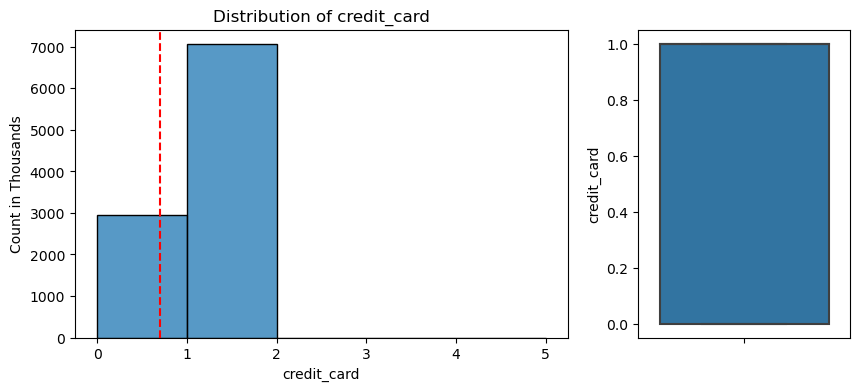

Percentage of Oultliers based on Inter Quartile Range 0.0%


In [24]:
Dist_Plot(df_churn_original,'credit_card',"Distribution of " + 'credit_card', 'credit_card', "Count in Thousands", 1, 6)
print("===============================================================")

#### Distribution of Estimated Customer Salary

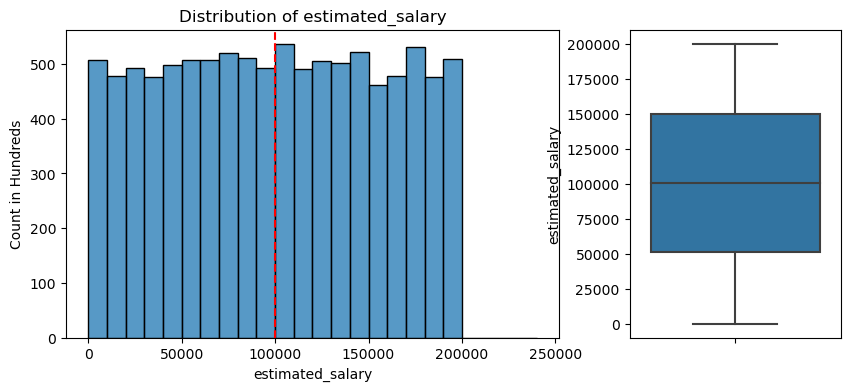

Percentage of Oultliers based on Inter Quartile Range 0.0%


In [25]:
Dist_Plot(df_churn_original,'estimated_salary',"Distribution of " + 'estimated_salary', 'estimated_salary', "Count in Hundreds", 10000, 25)
print("===============================================================")

#### Histogram of Dependent Variable - churn

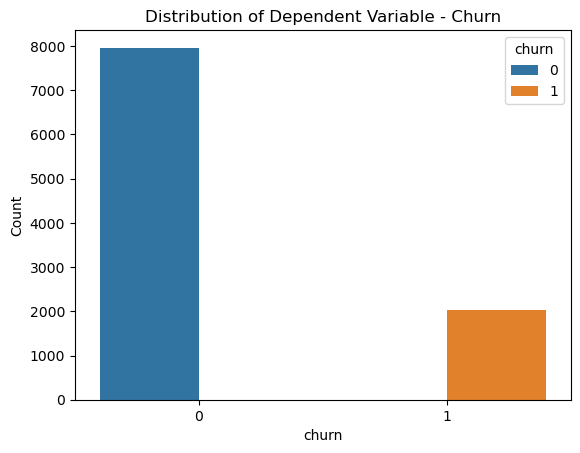

0    7963
1    2037
Name: churn, dtype: int64

 Classes are highly imbalanced with Non-Churn observations constituting 79.63% of the data


In [26]:
target_val_counts = pd.value_counts(df_churn_original.churn)
target_count = sns.countplot(data=df_churn_original, x="churn", hue="churn")
target_count.set_title("Distribution of Dependent Variable - Churn")
target_count.set_ylabel("Count")
plt.show()
print(target_val_counts)
print("\n Classes are highly imbalanced with Non-Churn observations constituting {}% of the data".format(target_val_counts[0]/df_churn_original.shape[0]*100))

#### Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

We will be using 3 methods to understand the most important features from the Dataset
* Principal Component Analysis - PCA
* Random Forest
* XGBoost


##### Principal Component Analysis - PCA



In [27]:
# dummy encode categorical variables
df_encoded = pd.get_dummies(df_churn_original, columns=['country', 'gender', 'active_member'], drop_first=True)

df_encoded['churn'] = pd.Categorical(df_churn_original['churn'])


([<matplotlib.axis.XTick at 0x15f988f90>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

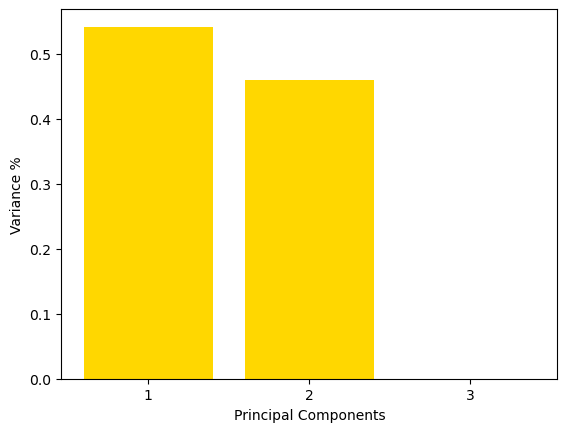

In [28]:
## PCA

pca = PCA(n_components=3)
pca.fit(df_encoded)

# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

In [29]:
# Variable Importance table
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=df_encoded.columns,index=PCnames)
Loadings

,credit_score,age,tenure,balance,products_number,credit_card,estimated_salary,churn,country_Germany,country_Spain,gender_Male,active_member_1
PC1,0.000010,0.000005,-5.399443e-07,0.99698,-2.814867e-06,-1.133091e-07,0.077660,7.676894e-07,2.781163e-06,-9.327881e-07,9.144193e-08,-8.699703e-08
PC2,0.000003,0.000002,-4.426657e-07,0.07766,-4.028806e-07,6.864755e-08,-0.996980,-1.453245e-08,1.775875e-07,-3.684491e-08,7.892823e-08,9.167353e-08
PC3,-1.000000,0.000456,-2.788004e-05,0.00001,-8.529393e-05,2.537047e-05,-0.000002,1.159998e-04,-1.358780e-05,-2.509523e-05,1.516278e-05,-1.328724e-04


##### Random Forest

In [30]:
# Create a feature set and target variable
X = df_encoded.loc[:, df_encoded.columns != 'churn']
y = pd.Categorical(df_encoded['churn'])

feature_names = X.columns

# Run Random Forest Classifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)


RandomForestClassifier(random_state=0)

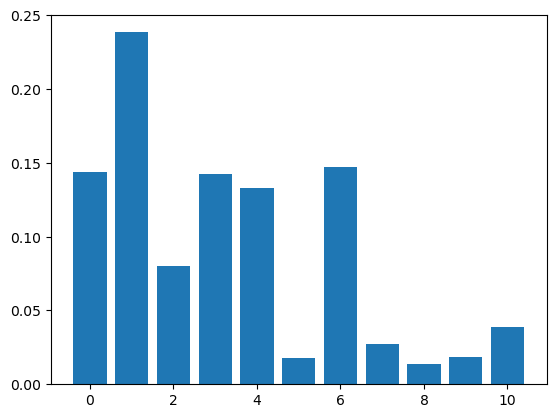

In [31]:
# Variable Importance Plot

forest_importances = pd.Series(forest.feature_importances_, index=feature_names)
plt.bar([x for x in range(len(forest_importances))], forest_importances)
plt.show()

In [32]:
# Variable Importance Table
forest_importances


credit_score        0.143450
age                 0.238372
tenure              0.079978
balance             0.142234
products_number     0.132891
credit_card         0.017870
estimated_salary    0.146830
country_Germany     0.027171
country_Spain       0.013831
gender_Male         0.018338
active_member_1     0.039035
dtype: float64

##### XGBoost

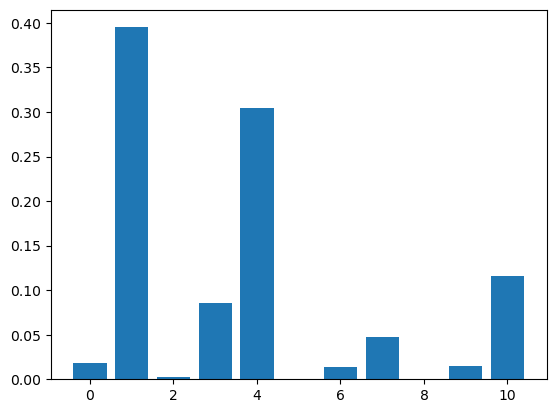

In [33]:
## XGBoost Classifier
xgboost = GradientBoostingClassifier()
xgboost.fit(X, y)

## Get Variable Importance Plot
xgboost_importances = pd.Series(xgboost.feature_importances_, index=feature_names)
plt.bar([x for x in range(len(xgboost_importances))], xgboost_importances)
plt.show()

In [34]:
 # Variable Importance table
 xgboost_importances

credit_score        0.017855
age                 0.395083
tenure              0.002800
balance             0.086047
products_number     0.304555
credit_card         0.000284
estimated_salary    0.014231
country_Germany     0.047929
country_Spain       0.000209
gender_Male         0.014698
active_member_1     0.116308
dtype: float64

Based on the variable importance plots the variables below are useful for training the model
* age
* products_number

### Which independent variables have missing data? How much?

From our analysis from the EDA section it is observed that None of the predictor variables have missing data

### Is the predictor variables independent of all the other predictor variables?

#### Pairwise Correlation

Running Pairwise Correlation to check if there are any relationships between independent variables

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

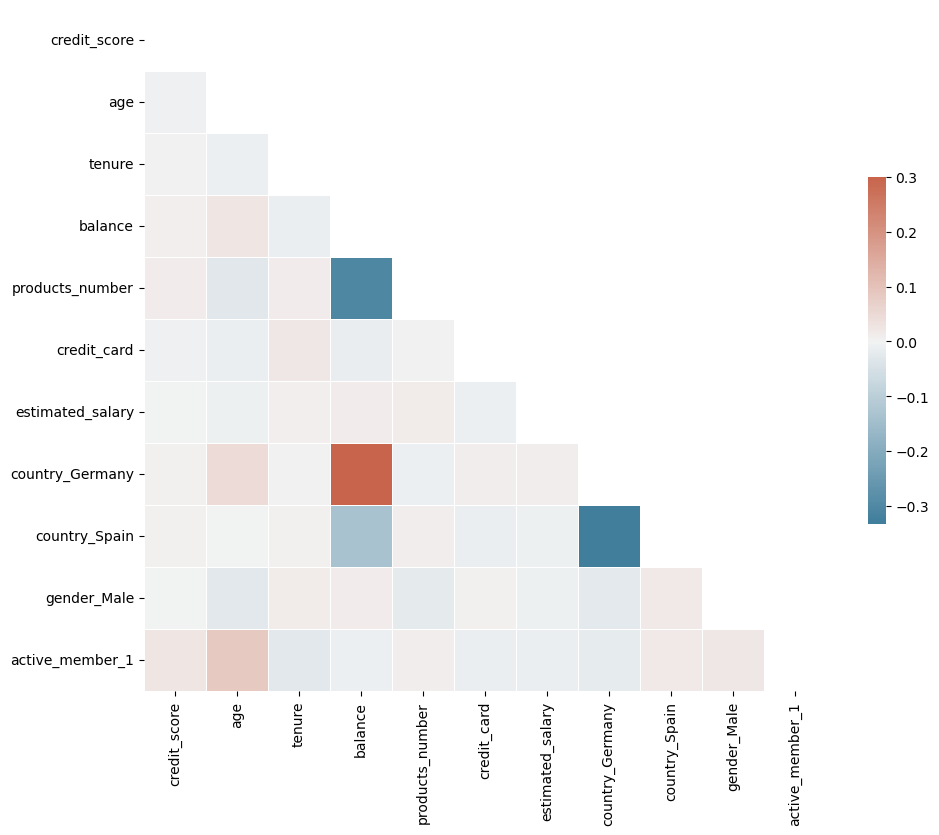

In [35]:
# Compute the correlation matrix
corr = df_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the Pairwise correlation plot it is evident that there are no pairs of variables that are highly correlated with each other

#### Which predictor variables are the most important?

Based on the variable importance plots the variables below are useful for training the model

* age
* products_number

## AutoML

We will use H20 AutoML to determine important features, identify the train-test data, and build models for binary classification. This section helps us answer the below questions:

### Do the training and test sets have the same data?
* We will be performing stratefied sampling to get the Train and Test Split as this would ensure that the test set has a significant amount of observations from both classes and help provide a variance similar to the train data

#### Which predictor variables are the most important?

#### Remove outliers and keep outliers (does if have an effect of the final predictive model)?

* Initially we will fit the model using data containing outliers and then fit the model on data that doesn't contain outliers to compare the influence of outliers on  the prediction task.



### Modeling with outliers

In [36]:
# Load your dataset into H2O
data_churn = h2o.import_file("Bank Customer Churn Prediction.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [37]:
data_churn['churn'] = data_churn['churn'].asfactor()
data_churn = data_churn.drop('customer_id', axis=1)

In [38]:
data_churn

credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
619,France,Female,42,2,0,1,1,1,101349,1
608,Spain,Female,41,1,83807.9,1,0,1,112543,0
502,France,Female,42,8,159661,3,1,0,113932,1
699,France,Female,39,1,0,2,0,0,93826.6,0
850,Spain,Female,43,2,125511,1,1,1,79084.1,0
645,Spain,Male,44,8,113756,2,1,0,149757,1
822,France,Male,50,7,0,2,1,1,10062.8,0
376,Germany,Female,29,4,115047,4,1,0,119347,1
501,France,Male,44,4,142051,2,0,1,74940.5,0
684,France,Male,27,2,134604,1,1,1,71725.7,0


While training the model, we will perform stratified sampling since the classes are imbalanced

In [39]:
# Define features and target variable
x = data_churn.columns[:-1]  # Features
y = data_churn.columns[-1]   # Target variable

# Split the data into train and test sets
# train, test = data_churn.split_frame(ratios=[0.8], seed=42)
train, test = data_churn.split_frame(ratios=[0.8], seed=42, destination_frames=["train", "test"])


In [40]:
train

credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
619,France,Female,42,2,0,1,1,1,101349,1
608,Spain,Female,41,1,83807.9,1,0,1,112543,0
502,France,Female,42,8,159661,3,1,0,113932,1
699,France,Female,39,1,0,2,0,0,93826.6,0
850,Spain,Female,43,2,125511,1,1,1,79084.1,0
645,Spain,Male,44,8,113756,2,1,0,149757,1
822,France,Male,50,7,0,2,1,1,10062.8,0
376,Germany,Female,29,4,115047,4,1,0,119347,1
501,France,Male,44,4,142051,2,0,1,74940.5,0
684,France,Male,27,2,134604,1,1,1,71725.7,0


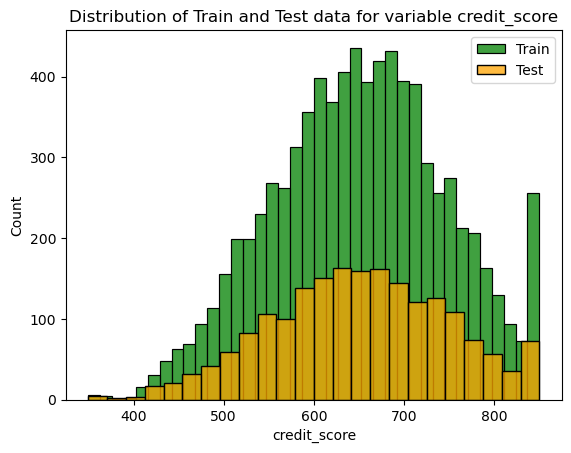

<Figure size 600x600 with 0 Axes>

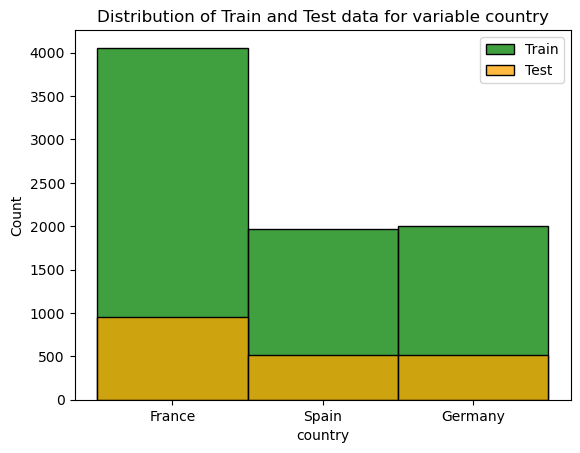

<Figure size 600x600 with 0 Axes>

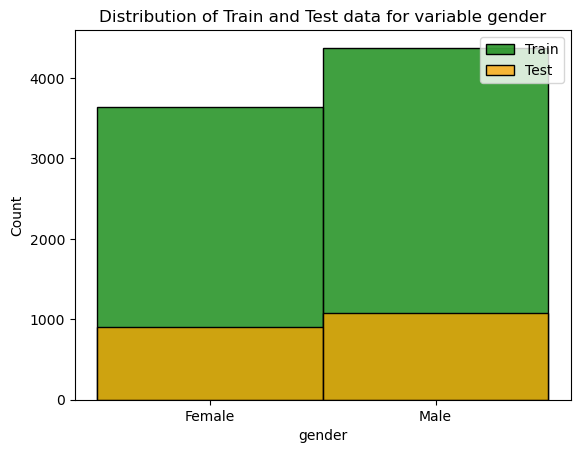

<Figure size 600x600 with 0 Axes>

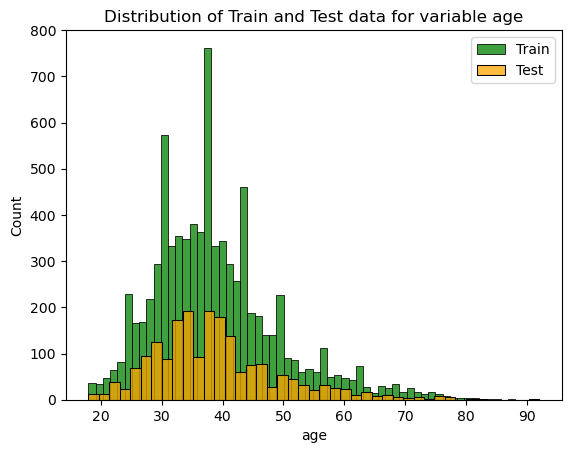

<Figure size 600x600 with 0 Axes>

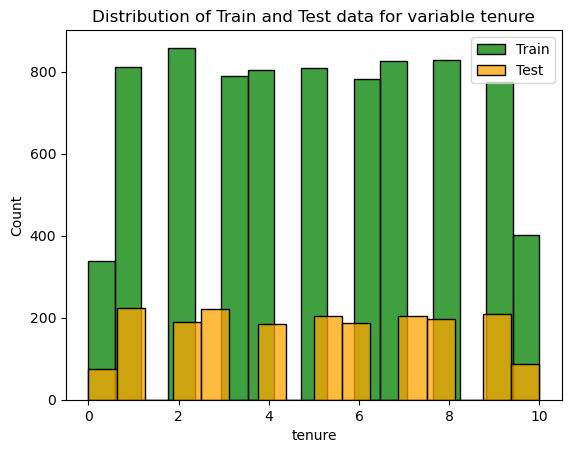

<Figure size 600x600 with 0 Axes>

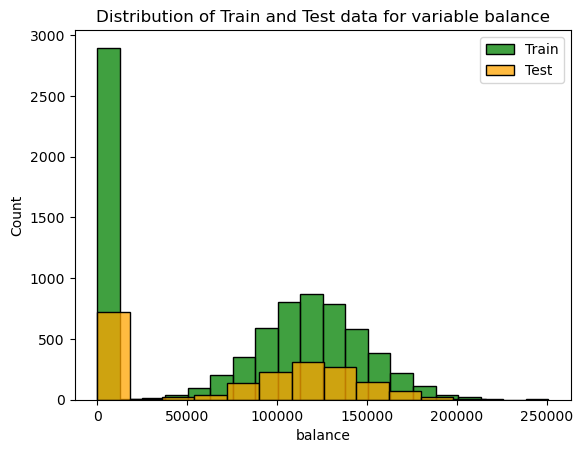

<Figure size 600x600 with 0 Axes>

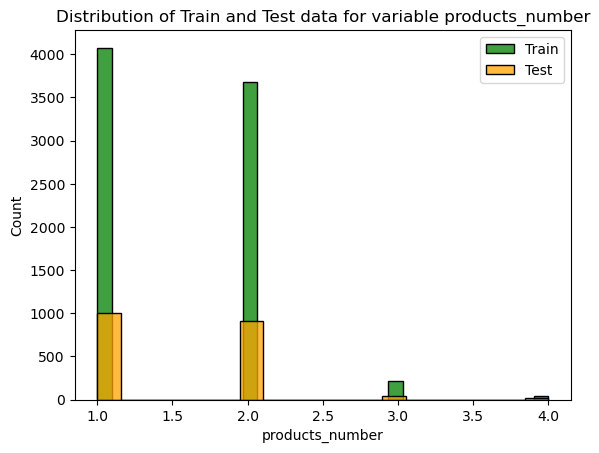

<Figure size 600x600 with 0 Axes>

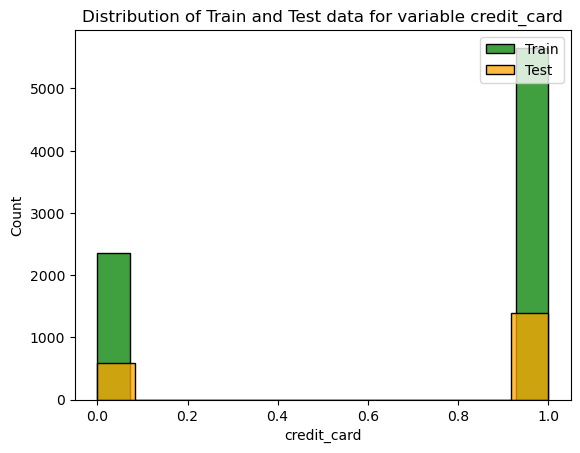

<Figure size 600x600 with 0 Axes>

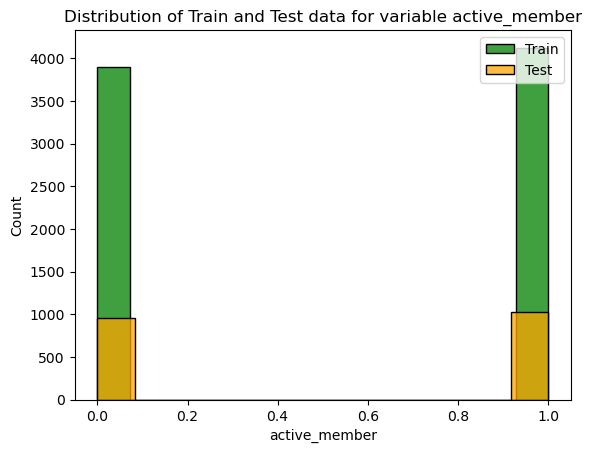

<Figure size 600x600 with 0 Axes>

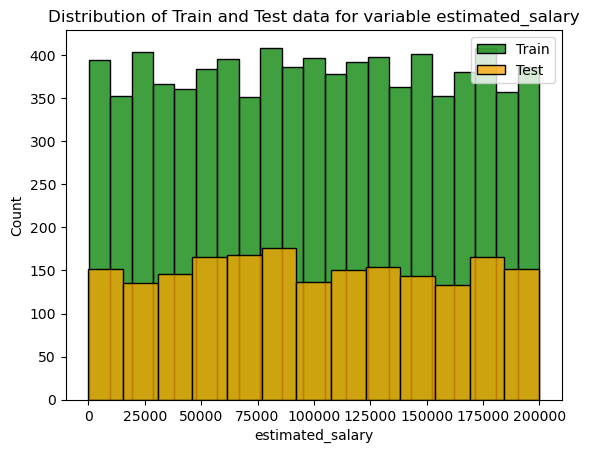

<Figure size 600x600 with 0 Axes>

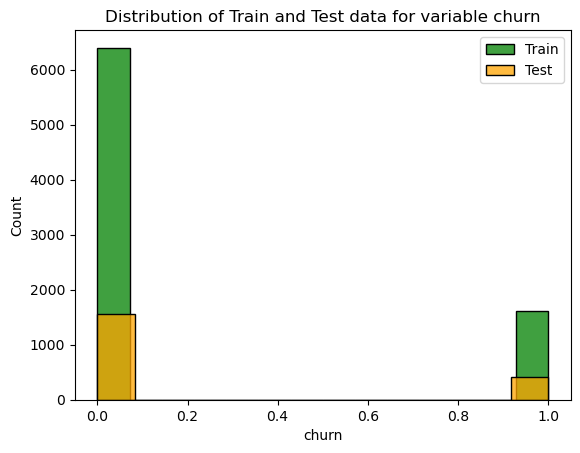

<Figure size 600x600 with 0 Axes>

In [41]:
# Function to plot distributions of Train and Test data
exclude_algos = ["StackedEnsemble"]

def Plot_Dis(df, column, title, xLabel, yLabel, mul_factor, amount_limit, bar_color):

    # Density plot
    # bins_var = [0]
    # if time_step == True:
    #     mul_factor = 15
    #     amount_limit = 50
    #     for i in range(1,amount_limit):
    #         bins_var.append(i*mul_factor)
    # else:
    #     for i in range(1,amount_limit):
    #         bins_var.append(i*mul_factor)

    amt_plot = sns.histplot(data=df, x=column, color=bar_color)
    amt_plot.set_xlabel(xLabel)
    amt_plot.set_ylabel(yLabel)
    amt_plot.set_title(title)


# Iterate over numeric columns
for i in train.as_data_frame().columns:


    Plot_Dis(train.as_data_frame(), i, "Distribution of Train and Test data for variable "+ i,i, 'Count', 2, 40, 'green')

    Plot_Dis(test.as_data_frame(), i, "Distribution of Train and Test data for variable "+i,i, 'Count', 2, 40, 'orange')
    plt.legend(loc='upper right', labels=['Train', 'Test'])
    plt.figure(figsize=(6,6))
    plt.show()




In [45]:
# Initialize and train the AutoML model
aml = H2OAutoML(max_models=20, seed=42, exclude_algos=["StackedEnsemble"],max_runtime_secs=1200,nfolds=5,balance_classes=True)
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |
01:11:47.920: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████

In [ ]:
# View the leaderboard (models ranked by performance)
leaderboard = aml.leaderboard
leaderboard


In [ ]:
# Get the best model
best_model = aml.leader

In [ ]:
# Make predictions on the test set
predictions = best_model.predict(test)

# View the predictions
predictions

In [ ]:
perf = best_model.model_performance(test)
perf

##### Model Metrics on train data

In [ ]:
best_model

##### Model metrics on test data

In [ ]:
perf

**Findings - metrics comparison**

Comparing metrics such as MSE, RMSE, LogLoss,Mean Per-Class Error, AUC for both test and training data from cross-validation, we see that the difference in metrics is marginal. Hence, it is evident that the model has not overfit on training data.


### Modeling after Removal of Outliers

In [ ]:
### Remove outliers from Data based on Inter Quartile Range(IQR)

##IQR = Quartile3 – Quartile1
## Function to identify outliers.
## Returns lists of row numbers of upper outliers and lower outliers for each numeric variable

def IQR(df, column):

    # Calculate Quartile 1 and Quartile 3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Inter Quartile Range
    IQR = Q3 - Q1

    # Calculate the upper and lower limits
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df[column]>=upper)[0]
    lower_array = np.where(df[column]<=lower)[0]

    return upper_array, lower_array


In [ ]:
# Function to plot histogram of Class Distribution of Outliers present in numeric variables

def Plot_Hist_Class_Outlier(class_list, column):

    plt.figure(figsize=(4,4))
    plt.xlabel('Classes')
    plt.xticks([0,1])
    plt.title('Class Distribution of Outliers present in ' + column)
    plt.ylabel('Class Count in Thousands')
    plt.hist(class_list)
    plt.show()

In [ ]:
# Get the class distribution of Outliers for each numeric variable

# List to store outliers cross each numeric column
outliers = []

# iterate over numeric columns
for col in numeric_columns:

    # Call IQR function to get upper and lower outliers
    upper_array, lower_array = IQR(data_churn.as_data_frame(), col)

    class_labels = []

    # check if the outlier list is empty
    if len(upper_array) > 0:
        for i in upper_array:

            # get class labels for each outlier using row number
            c_label = data_churn.as_data_frame()['churn'][i]
            if c_label == 0:
                outliers.append(i)
            class_labels.append(data_churn.as_data_frame()['churn'][i])

        # Function to plot histogram of classes
        Plot_Hist_Class_Outlier(class_labels, col)



In [ ]:
# Removing Outliers from the Data
outliers = list(set(outliers))

# make a copy of original data for further analysis before removing outliers
data_churn_copy = data_churn.as_data_frame().copy()

# Remove outliers

keep_rows_index = h2o.H2OFrame(list(map(lambda x: x not in outliers, range(data_churn.nrow))))

# Remove rows based on the logical index
filtered_frame = data_churn[keep_rows_index, :]



In [ ]:
data_churn = filtered_frame

In [ ]:
# Define features and target variable
x = data_churn.columns[:-1]  # Features
y = data_churn.columns[-1]   # Target variable

# Split the data into train and test sets
train, test = data_churn.split_frame(ratios=[0.8], seed=42, destination_frames=["train", "test"])



In [ ]:
# Plotting the distribution plot for train and test data

# Iterate over numeric columns
for i in train.as_data_frame().columns:


    Plot_Dis(train.as_data_frame(), i, "Distribution of Train and Test data for variable "+ i,i, 'Count', 2, 40, 'green')

    Plot_Dis(test.as_data_frame(), i, "Distribution of Train and Test data for variable "+i,i, 'Count', 2, 40, 'orange')
    plt.legend(loc='upper right', labels=['Train', 'Test'])
    plt.figure(figsize=(6,6))
    plt.show()

In [ ]:
# Initialize and train the AutoML model

aml = H2OAutoML(max_models=20, seed=42, exclude_algos=["StackedEnsemble"], max_runtime_secs=1200,nfolds=5,balance_classes=True)
aml.train(x=x, y=y, training_frame=train)


In [ ]:
# View the leaderboard (models ranked by performance)
leaderboard = aml.leaderboard
leaderboard


In [ ]:
# Get the best model
best_model = aml.leader

In [ ]:
# Make predictions on the test set
predictions = best_model.predict(test)

# View the predictions
predictions

In [ ]:
perf = best_model.model_performance(test)
perf

##### Model Metrics on train data

In [ ]:
best_model

##### Model Metrics on test data

In [ ]:
perf

#### Impact of Outliers on the model
**Findings**

Comparing the test accuracy of both the models before and after removing outliers, it is evident that there no significant improvement
* with outliers - 86.5%
* without outlierS - 86.77%

Model Overfitting

**Findings - metrics comparison**

Comparing metrics such as MSE, RMSE, LogLoss,Mean Per-Class Error, AUC for both test and training data from cross-validation, we see that the difference in metrics is marginal. Hence, it is evident that the model has not overfit on training data.


### Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values? That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error. For categorical data, calculate the accuracy and a confusion matrix.

In [ ]:

# Function to Remove Data
def remove_random_data(df, percent_to_remove):
    num_rows_to_remove = int(len(df) * percent_to_remove)
    indices_to_remove = np.random.choice(df.index, num_rows_to_remove, replace=False)
    df_missing = df.copy()
    df_missing.loc[indices_to_remove, 'numeric_column'] = np.nan
    df_missing.loc[indices_to_remove, 'categorical_column'] = np.nan
    return df_missing



In [ ]:
# Function to Imputate Data
def impute_data(df_missing, num_cols, cat_cols):
    # Impute numeric columns - impute mean
    numeric_imputer = SimpleImputer(strategy='mean')

    for i in num_cols:
      df_missing[i+'imputed'] = numeric_imputer.fit_transform(df_missing[[i]])

    #K-Nearest Neighbors (KNN) Imputation for Numeric Data
    knn_imputer = KNNImputer(n_neighbors=3)
    for i in num_cols:
      df_missing[i+'KNNimputed'] = knn_imputer.fit_transform(df_missing[[i]])

    # Impute categorical columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    for i in cat_cols:
      df_missing[i+'imputed'] = categorical_imputer.fit_transform(df_missing[[i]])

    return df_missing



In [ ]:
# Function to Check % Error on Residuals for Numeric Data
def calculate_residuals(df_original, df_imputed, numeric_column):
    residuals = df_original[numeric_column] - df_imputed[numeric_column]
    percent_error = (abs(residuals) / df_original[numeric_column]).mean() * 100
    return percent_error

# Function to Check for Bias and Variance of the Error
def analyze_error(df_original, df_imputed, numeric_column):
    residuals = df_original[numeric_column] - df_imputed[numeric_column]
    bias = residuals.mean()
    variance = residuals.var()
    return bias, variance



In [ ]:
# Calculate Accuracy and Confusion Matrix for Categorical Data
def evaluate_categorical_accuracy(df_original, df_imputed, cat_col):
    accuracy = accuracy_score(df_original[cat_col], df_imputed[cat_col])
    confusion_mat = confusion_matrix(df_original[cat_col], df_imputed[cat_col])
    return accuracy, confusion_mat




#### Remove 1% Data

In [ ]:
# Remove 1% of data
df_missing_1_percent = remove_random_data(df_churn_original, 0.01)

# Impute data
df_imputed = impute_data(df_missing_1_percent, numeric_columns, cat_cols)

# Check % Error on Residuals for Numeric Data
for i in numeric_columns:
  percent_error = calculate_residuals(df_churn_original, df_imputed, i)
  print(f'Percent Error on Residuals: {percent_error:.2f}%')

# Check for Bias and Variance of the Error
for i in numeric_columns:
  bias, variance = analyze_error(df_churn_original, df_imputed, i)
  print(f'Bias: {bias:.2f}, Variance: {variance:.2f}')

# Calculate Accuracy and Confusion Matrix for Categorical Data
for i in cat_cols:
  accuracy, confusion_mat = evaluate_categorical_accuracy(df_churn_original, df_imputed, i)
  print(f'Accuracy: {accuracy:.2f}')
  print('Confusion Matrix:')
  print(confusion_mat)


#### Remove 5% Data

In [ ]:
# Remove 5% of data
df_missing_5_percent = remove_random_data(df_churn_original, 0.05)

# Impute data
df_imputed = impute_data(df_missing_5_percent, numeric_columns, cat_cols)

# Check % Error on Residuals for Numeric Data
for i in numeric_columns:
  percent_error = calculate_residuals(df_churn_original, df_imputed, i)
  print(f'Percent Error on Residuals: {percent_error:.2f}%')

# Check for Bias and Variance of the Error
for i in numeric_columns:
  bias, variance = analyze_error(df_churn_original, df_imputed, i)
  print(f'Bias: {bias:.2f}, Variance: {variance:.2f}')

# Calculate Accuracy and Confusion Matrix for Categorical Data
for i in cat_cols:
  accuracy, confusion_mat = evaluate_categorical_accuracy(df_churn_original, df_imputed, i)
  print(f'Accuracy: {accuracy:.2f}')
  print('Confusion Matrix:')
  print(confusion_mat)


#### Remove 10% Data

In [ ]:
# Remove 10% of data
df_missing_10_percent = remove_random_data(df_churn_original, 0.1)

# Impute data
df_imputed = impute_data(df_missing_10_percent, numeric_columns, cat_cols)

# Check % Error on Residuals for Numeric Data
for i in numeric_columns:
  percent_error = calculate_residuals(df_churn_original, df_imputed, i)
  print(f'Percent Error on Residuals: {percent_error:.2f}%')

# Check for Bias and Variance of the Error
for i in numeric_columns:
  bias, variance = analyze_error(df_churn_original, df_imputed, i)
  print(f'Bias: {bias:.2f}, Variance: {variance:.2f}')

# Calculate Accuracy and Confusion Matrix for Categorical Data
for i in cat_cols:
  accuracy, confusion_mat = evaluate_categorical_accuracy(df_churn_original, df_imputed, i)
  print(f'Accuracy: {accuracy:.2f}')
  print('Confusion Matrix:')
  print(confusion_mat)


#### Analyse relation between independent and dependent variable

- **Point Biserial Correlation**

Since the dataset is a classification dataset and the target variable is categorical, we can't use Pearson Correlation. In this case, we use the Point-Biserial Correlation, which assesses the association between a binary variable (the target variable) and a continuous variable (a feature) to understand the relation between independent and dependent variable.

- **Chi Square test**

This test helps us understand the significance of an independent categorical variable with the target categorical variable

In [ ]:
# Dataframe to store p_vals for each independent variable
df_corr_coef = pd.DataFrame()

corr_coef = {}

# Calculate Point Biserial Correlation for all continuous variables

for i in numeric_columns:

    pt_bs, p_val = stats.pointbiserialr(df_churn_original['churn'], df_churn_original[i])
    print(p_val)
    corr_coef[i] = round(p_val,4)

    # Determine significance
    alpha = 0.05
    if p_val < alpha:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")



df_corr_coef['features'] = corr_coef.keys()
df_corr_coef['p_value'] = corr_coef.values()

# Add column to state the significance value of each feature
df_corr_coef['p<0.05'] = df_corr_coef['p_value'].apply(lambda x: True if x < 0.05 else False)

In [ ]:
# Chi Square test
cat_cols = df_churn_original.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.pop(-1)

for i in cat_cols:
    print(i)
    # Create a contingency table
    contingency_table = pd.crosstab(df_churn_original[i], df_churn_original['churn'])

    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(p_value)

    # Determine significance
    alpha = 0.05
    signi = False
    if p_value < alpha:
        print("The correlation is statistically significant.")
        signi = True
    else:
        print("The correlation is not statistically significant.")

    df_corr_coef = df_corr_coef.append({'features':i,
                          'p_value': round(p_value, 4),
                          'p<0.05': signi}, ignore_index=True)

In [ ]:
df_corr_coef

**Findings**

From Point Biserial Correlation and chi sqaure test, we find that tenure, no of credits cards held(credit_card) and estimated_salary are not significant while predicting churn of a customer.

From Variable import scores obtained from AutoML metrics after the run,it is evident that tenure, no of credits cards held(credit_card) are among the least important features, however estimated_salary even though not part of top 5 important features, still has a minute influence.

We can further confirm this by getting the variable important scores by running random forest algorithm

In [ ]:
#### Random Forest - Variable Importance plot

# dummy encode categorical variables
df_encoded = pd.get_dummies(df_churn_original, columns=['country', 'gender', 'active_member'], drop_first=True)

df_encoded

In [ ]:
# h2o.init()
# Create a feature set and target variable
X = df_encoded.loc[:, df_encoded.columns != 'churn']
y = df_encoded['churn']

feature_names = X.columns

# Run Random Forest Classifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

In [ ]:
# Variable Importance Plot

forest_importances = pd.Series(forest.feature_importances_, index=feature_names)

# Create a DataFrame to store feature names and their importance scores
df_feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': forest_importances})

# Sort by importance
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel("Importance scores")
plt.title("Variable Importance Plot")
plt.show()

In [ ]:
# Variable Importance Table
forest_importances

From the variable importance scores, it is seen that estimated_salary is doesn't feature among the least important features, but it is seen that tenure and no of credi_cards are among the least important factors. Hence we, will be dropping these two features and re-run the Point Biserial Correlation as these are numeric columns

#### Point Biserial Correlation after removing insignificant features

In [ ]:
df_churn_sig = df_churn_original.drop(columns=['tenure','credit_card'])

numeric_columns_sig = df_churn_sig.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_columns_sig


In [ ]:
# Dataframe to store p_vals for each independent variable
df_corr_coef = pd.DataFrame()

corr_coef = {}

# Calculate Point Biserial Correlation for all continuous variables

for i in numeric_columns_sig:

    pt_bs, p_val = stats.pointbiserialr(df_churn_sig['churn'], df_churn_sig[i])
    print(p_val)
    corr_coef[i] = round(p_val,4)

    # Determine significance
    alpha = 0.05
    if p_val < alpha:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")



df_corr_coef['features'] = corr_coef.keys()
df_corr_coef['p_value'] = corr_coef.values()

# Add column to state the significance value of each feature
df_corr_coef['p<0.05'] = df_corr_coef['p_value'].apply(lambda x: True if x < 0.05 else False)

In [ ]:
df_corr_coef

We observe that all features except estimated_salary are significant, but we will retain estimated_salary based on our previous analysis from variable importance scores from the Random forest and GBM

#### Checking for Multicollinearity

To check for multicollinearity in the data, we will compute the correlation matrix on independent variables and plot Pairwise Correlation to check if there are any relationships between independent variables

In [ ]:

df_encoded_sig = pd.get_dummies(df_churn_sig, columns=['country', 'gender', 'active_member'], drop_first=True)

df_encoded_sig.corr()

In [ ]:
# Compute the correlation matrix
corr = df_encoded_sig.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
sns.pairplot(df_encoded_sig)

**Findings on Multicollinearity**

The correlation matrix and pairwise correlation plot show that there is no significant relationship among predictor variables

#### Re-running Automl after removing insignificant features

In [ ]:

df_churn_sig = h2o.import_file("Bank Customer Churn Prediction.csv")
# remove insignificant columns
col_remove = ['tenure','credit_card', 'customer_id']


df_churn_sig = df_churn_sig.as_data_frame().drop(col_remove, axis=1)
df_churn_sig['active_member'] = pd.Categorical(df_churn_sig['active_member'])
df_churn_sig['churn'] = pd.Categorical(df_churn_sig['churn'])
df_churn_sig = h2o.H2OFrame(df_churn_sig)

In [ ]:
# Define features and target variable
x = df_churn_sig.columns[:-1]  # Features
y = df_churn_sig.columns[-1]   # Target variable

# exclude_algos = ["StackedEnsemble", "StackedEnsemble_BestOfFamily", "StackedEnsemble_AllModels"]
# Split the data into train and test sets
train, test = df_churn_sig.split_frame(ratios=[0.8], seed=42)

# Initialize and train the AutoML model

aml = H2OAutoML(max_models=20, seed=42, exclude_algos=["StackedEnsemble"], max_runtime_secs=1200,nfolds=5,balance_classes=True)
aml.train(x=x, y=y, training_frame=train)


In [ ]:
# View the leaderboard (models ranked by performance)
leaderboard = aml.leaderboard
print(leaderboard)
# Get the best model
best_model = aml.leader

In [ ]:
# Make predictions on the test set
predictions = best_model.predict(test)

# View the predictions
print(predictions)

In [ ]:
perf = best_model.model_performance(test)
perf

#### Hyperparameter Tuning

Hyperparameter tuning is the process of finding the best combination of hyperparameters to achieve the best model performance on a dataset.

In [ ]:

# Define hyperparameter search space
hyperparameters = {
    'ntrees': [50, 100, 150],              # Number of trees in the ensemble
    'max_depth': [3, 5, 7],                # Maximum depth of the trees
    'min_rows': [10, 20, 30],             # Minimum number of observations in a leaf
    'learn_rate': [0.1, 0.01, 0.001]      # Learning rate
}

# Initialize the GBM model
gbm = H2OGradientBoostingEstimator()

# Perform grid search
grid = H2OGridSearch(gbm, hyperparameters)
grid.train(x=x, y=y, training_frame=train)

# Get the best model from the grid search
best_model = grid.get_grid()[0]


In [ ]:
# View the best hyperparameters
print("Best Hyperparameters:", best_model.get_params())



In [ ]:
best_model.model_performance()

## Model Interpretability

### **Fit Linear Model - Logistic Regression**

Since this is a classification problem, we will be fitting a Logistic regression model on the data, and interpret the co-efficients of each independent variable to understand the it's respective effect on the prediction of the target varible (churn). As the data is highly imbalanced we will be performing a stratefied sampling on the test set has a distribution that closely represents the original distribution.

In [ ]:
# dummy encode categorical variables
df_encoded = pd.get_dummies(df_churn_original, columns=['country', 'gender', 'active_member'], drop_first=True)

df_encoded['churn'] = pd.Categorical(df_churn_original['churn'])

In [ ]:
# Create a feature set and target variable
# df_encoded = df_encoded.drop(['customer_id'], axis=1)

X = df_encoded.loc[:, df_encoded.columns != 'churn']
y = df_encoded['churn']

# Performing Stratefied Sampling to generate a test set with 25% samples from each class
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_encoded[['churn']])


In [ ]:
# Train a logistic regression model
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_reg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Get the coefficients and intercept
coefficients = logistic_reg_model.coef_
intercept = logistic_reg_model.intercept_

# # Interpret the coefficients
# print("Co efficients of the model : \n")
# for feature, coef in zip(X_train.columns.to_list(), coefficients.tolist()[0]):
#     print(f"{feature}: {coef}")

print("------------------------------")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
# Predict probabilities on the test set
y_proba = logistic_reg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Interpret Co-efficients (β) of the *model*

#### Odds Ratio:

It represents the change in odds for a one-unit increase in the predictor variable. An odds ratio of 1 implies no change in odds, an odds ratio greater than 1 implies an increase in odds, and an odds ratio less than 1 implies a decrease in odds.

In [ ]:
# Create a summary DataFrame
summary_data = pd.DataFrame({'Feature': X_train.columns.to_list(), 'Coefficient': coefficients.tolist()[0]})
# summary_data.loc[len(summary_data)] = ['Intercept', intercept]
summary_data['Odds Ratio'] = np.exp(coefficients.tolist()[0])

# Display the summary
print("Logistic Regression Model Summary:")
print(summary_data)


# Model Intercept
print("\n Intercept : ", intercept)

**Findings**

* We observe that age has an odds ratio slightly greater than 1, which implies that there is a slight chance of customer churn based on age
* Account Balance is 1, which is neutral and does not have any effect on the prediction

#### Magnitude of Co-efficients

The magnitude of coefficients indicates the strength of the relationship. Larger coefficients have a more significant impact on the log-odds.

In [ ]:
# Create a bar plot for coefficient magnitudes
coefficients = np.abs(logistic_reg_model.coef_[0])
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.title('Absolute Magnitude of Logistic Regression Coefficients')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Names')
plt.show()

**Findings**

From the coefficient magnitude plot above we see that **age**, **credit_score** and **active_member** status are the top 3 most significant independent variables that impact the prediction of customer churn


#### Sign of Coefficients:

The sign of each coefficient (β) indicates the direction of the relationship with the log-odds of the positive outcome. Positive coefficients increase the log-odds, while negative coefficients decrease the log-odds.

In [ ]:
# Create a coefficient plot for signs
plt.figure(figsize=(10, 6))
sns.barplot(x=logistic_reg_model.coef_[0], y=feature_names)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.show()


**Findings**

The above plot signifies the relationship of the coeddicients on the log odds, mean positive relationship increases the possibility of churn, while -ve relationship reduces churn:

* age variable is positively impacts the posibility of churn
* credit_score; A person with a high credit score is less likely to churn, vice versa
* similarly for active_member status, an active customer is less likely to churn
* gender does significantly impact the prediction, where male customers are less likely to churn


### Fit a Tree Model - **Decision Tree**

We will fit a Decision Tree on the data and understand the branching conditions and node characteristics. We will visualize the tree to interpret the node attributes and branch conditions. For ease of interpretation we have limited the max depth of the decision tree to 3

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# df_tree = df_encoded.drop(['customer_id'], axis=1)

df_tree = df_encoded.copy()
df_tree['churn'] = pd.Categorical(df_tree['churn'])

X = df_tree.loc[:, df_tree.columns != 'churn']
y = df_tree['churn']

# Performing Stratefied Sampling to generate a test set with 25% samples from each class
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_tree[['churn']])


# Fit the tree-based model
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train, y_train)

# Interpret the nodes
tree_rules = export_text(tree_model, feature_names=list(X.columns))
print(tree_rules)

### Interpret Decision Tree

As seen above, age is the most prominent feature, as it impacts the decision of creating branches at the top order of the tree. active_member status and products_number features significantly impact the further creation of the nodes.

In [ ]:
# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report_str)

#### Decision Tree Visualization

In [ ]:
plt.figure(figsize=(64, 32))
plot_tree(tree_model, filled=True, feature_names=X_train.columns.to_list(), class_names=X_train.columns.to_list(), rounded=True)
plt.show()

**Findings**

* We see that age, products_number, and active_member status have a high influence on the process of creating a decision
* As observed on the left sub tree pertaining to products_number as the decision feature, we see that the gini impurity is reducing as the nodes go deeper indicating the formation of pure nodes(having instances belonging to the same class)
* The threshold of the root node(age) depicts that ~80% of the population is <= 42 years
* The left tree generated via products_number feature depicts the skewed nature of the data, with over 85% of the population subscribing to < 2 bank products

### Interpret  Best Model from AutoML

We will be using the best model from the automl section above

In [ ]:
# Best Model

perf = best_model.model_performance(test)
perf

In [ ]:
# Make predictions on the test set
predictions = best_model.predict(test)

# View the predictions
predictions

### Interpret the automl model summary

**Findings**

* Types of models utilized for training and testing : tree based models (GBM), Deep Learning Models etc
* We observe that Gradient Boosting Machine with the hyperparameters (number_of_trees:46, min_depth:9, max_depth:15) is the top performing model with a mean accuracy of ~84.8%
* age, products_number and balance are the 3 most important features impacting the predictions of the model

## SHapley Additive exPlanations (SHAP) Analysis

SHAP values help in explaining the output of any machine learning model. SHAP values depict the significance of each feature over other features and each feature's contribution to final prediction.


### Logistic Regression

In [ ]:
# For linear model
explainer_linear = shap.Explainer(logistic_reg_model.predict, X_train)
shap_values_linear = explainer_linear.shap_values(X_test)

# Visualize SHAP values (example for linear model)
shap.summary_plot(shap_values_linear, X_test)

**Findings**

* age has the highest impact on positively affectively the model's predictions when identifying a highly likely scenario of a customer churn
* High credit_score implies lower churn rate, lower credit score implies higher churn rate
* Balance is evenly distributed
* Higher Estimated salary - lower churn rate

### Decision Tree



In [ ]:
# For tree-based model
explainer_tree = shap.TreeExplainer(tree_model)
shap_values_tree = explainer_tree.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values_tree, X_test)

In [ ]:
# Decision Tree model
explainer_tree = shap.Explainer(tree_model.predict, X_train)
shap_values_tree = explainer_tree.shap_values(X_test)
# Visualize SHAP values
shap.summary_plot(shap_values_tree, X_test)

**Findings**

* age, products_number and active_member status are most significant variables influencing the model's prediction
* An increase in age results in increase in the chance of churn
* An active_member is less likely to churn

### AutoML best model - Gradient Boosting Machine


In [ ]:

# best_model.explain(frame=data_churn)
best_model.shap_summary_plot(frame=data_churn)

**Findings**

* age, products_number and active_member status are most significant variables influencing the model's prediction
* customer with higher product subscription is less likely to churn, except for a few exceptions as seen from the sparse sequence of observations in the graph above
* Higher activity lower churn rate

## Partial Dependence Plots (PDP)

Partial Dependence Plots help in interpreting the impact of individual features on the model's predictions by providing insights into the relationship between a feature and the predicted response of the target. It shows the marginal effect of a feature on the predicted outcome of a machine learning model while keeping other features constant.

### Logistic Regression

In [ ]:
for i in X_train.columns.to_list():
#     print(i)
    PartialDependenceDisplay.from_estimator(logistic_reg_model, X_train, [i])

**Findings**

* credit_score, tenure, products_number,credit_card, estimated_salary, gender and active_member status lower the possibility of churn. A higher value of these variables indicates lower churn rate
* as balance and age increases, the model predicts a higher probability of customer churn

### Decision Tree

In [ ]:
for i in X_train.columns.to_list():
    PartialDependenceDisplay.from_estimator(tree_model, X_train, [i])

**Findings**

* an increase in age and balance results in higher churn rate
* Higher activity implies lower churn

### AutoML - Gradient Boosting Machine

In [ ]:
for i in train.col_names:
    best_model.pd_plot(frame=train, column=i)

**Findings**

* an increase in age and balance results in higher churn rate
* Higher activity implies lower churn

## Individual conditional expectation (ICE) plots

Individual conditional expectation (ICE) plots are similar to Partial Dependence Plots, where ICE plots are used to interpret the effect of individual instances of features, and helps in understanding the change caused in the predictions when the value of a specific features changes.  

### Logistic Regression

In [ ]:
for i in X_train.columns.to_list():
    PartialDependenceDisplay.from_estimator(logistic_reg_model, X_train, [i], kind='individual')

### Decision Tree

In [ ]:
for i in X_train.columns.to_list():
    PartialDependenceDisplay.from_estimator(tree_model, X_train, [i], kind='individual')

### AutoML - Gradient Boosting Machine

In [ ]:
feature_cols=['credit_score','country','gender','age','tenure','balance','products_number','credit_card','active_member','estimated_salary']

In [ ]:
for i in feature_cols:
    best_model.ice_plot(frame=train, column=i)

**Q. Is the relationship significant?**

We can infer if the relation in the model is significant by first computing the significance values of independent variables with the dependent variable. We check the obtained p values to determine if the relations are statistically significant. Variables with a p value < 0.05 are said to be significant. From the above analysis it is seen that credit_score, products_number, active_member status are some of the significant features, which draws parallel to real world, where an active customer, who has subscribed to many services offered by the bank and holds the a good credit score is unlikely to churn, and vice versa. Hence, we can conclude that the relationship is significant.

**Q. Are any model assumptions violated?**

Gradient Boosting Machines do not assume linear relationship the features and target variable, hence linearity is not relevant. However we can analyze the factors below to see if the model violates any of these assumptions

   **Overfitting:**

 A model is said to overfit if it performs well on training data and performs bad on test data. Comparing metrics such as MSE, RMSE, LogLoss,Mean Per-Class Error, AUC for both test and training data from cross-validation, we see that the difference in metrics is marginal. Hence, it is evident that the model has not overfit on training data.Therefore this assumption is not violated.


   **Data Imbalance:**

  If the data contains highly imbalanced classes then the model training process, is affected, where the model gets inclined to the majority class. This can be resolved by performing stratefied sampling, where we take a percentage of sample from each distribution which is representative of its parent distribution, while training a model, to ensure variance in the data. We are also performing k-fold cross validation to reduce the chances of overfitting and reduce bias towards majority class. Hence this assumption is not violated.

   **Feature Importance:**

  The features ranked by the model is in concurrence with the Point Biserial correlation, Chi square test and Variable importance scores provided by Random Forest algorithm. The model ranks credit_score, products_number, active_member status as some of the significant features, which is commensurate with real world scenarios, where an active customer, who has subscribed to many services offered by the bank and holds the a good credit score is unlikely to churn, and vice versa. Hence this assumption is not violated.

   **Multicollinearity:**

   It is observed that predictor variables don't have high correlation amongst themselves. Hence this assumption is not violated.

**Q. Is there any multicollinearity in the model?**

As observed from the correlation matrix, it is evident that the correlation coefficient values range between -3 and +3, which signifies that there is no relationship among independent variables. The pairwise correlation plot also depicts that there is no relationship between any 2 combination of predictor variables, hence it is safe to conclude that multicollinearity doesn't exist among predictor variables in the data.


**Q. In the multivariate models are predictor variables independent of all the other predictor variables?**

Predictor variables are said to be independent of other predictor variables when there is no relation between them.
As seen from the correlation matrix and the pairwise plot there is no relation(linear or non linear) between any two predictor variables.


**Q. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

From the Variable Importance scores, Point Biserial correlation and Chi Square test, "age", "products_number", "balance" are the top 3 most significant predictor variables. "tenure" and "credit_card" have p values greater than 0.05, hence we have excluded these variables, however, even though estimated_salary has p value > 0.05, but it appears in middle order when ranking the independent variables using importance scores, hence we retain it for the analysis.

**Does the model make sense?**

To determine if the model makes sense:
* is the model overfitting on the training data?
* are the top ranked features by the model close to real world?
* are the evaluation metrics significant?

From our analysis, we observe that the model has not violated any of previously mentioned assumptions. The top ranked features features are coinciding with the real world settings. The model produces a test accuracy of ~86%.The availability of more data and balanced class distributions would help to further improve the model metrics.

**Q. Does regularization help?**

Regularization in machine learning is done to prevent overfitting and help the model to generalize on unseen data. In Gradient Boosting Machine (GBM), regularization is performed by tuning hyperparameters that control the complexity of the model. We doesn't use L1 or L2 regularization like linear models in GBMs, however by tweaking certain hyperparameters that control the tree structure and learning process we can perform regularization. H2O autoML by default doesn't tweak these hyperparameters. We can run the H2OGradientBoostingEstimator as shown above to get the best set of hyperparameters. On performing this step we can see that there is an improvement in model performance, hence for this dataset we can conclude that regularization has influenced the model performance.


MSE: 0.061434731742438166
RMSE: 0.2478603069118534
MAE: 0.15707725716031035
RMSLE: 0.17252003151362363
Mean Residual Deviance: 0.061434731742438166

**Q. Which independent variables are significant?**

From our analysis based on Point Biserial Correlation, Chi Sqaure test and Variable Importance plot from random forest it is found that the folowing features are significant:

**features**	-    **p_value**

credit_score	- 0.0067

age	            - 0.0000

balance	        - 0.0000

products_number	- 0.0000

country	        - 0.0000

gender	        - 0.0000

active_member	- 0.0000

**Q. Which hyperparameters are important?**

In order to find the best combination of hyperparameters for a model, we perform hyperparamter tuning, to produce a model with the best performance for a dataset. Hyperparameter tuning, searches the best set of values for each hyperparameter based the limits and ranges specified.

H2O autoML framework uses the H2OGridSearch class. Grid search involves specifying a range of hyperparameter values to search over, and H2O will train a model for each combination of these values and evaluate their performance to determine the best set of hyperparameters. For this analysis we are using a Gradient Boosting Machine algorithm, and upon performing hyperparameter tuning it is found that the below hyperparameters are important
'ntrees': 50,
'max_depth': 5,  
'min_rows': 10,
'learn_rate': 0.1


## Conclusion

The Gradient Boosting Machine Model performed well on the customer churn dataset giving a 86% accuracy, even with imbalanced classes with non churn having the most number of observations. Performing cross-validation and stratefied sampling while training helped reduce bias and increase the variance of the model which was evident from the predictions on the test data. Hyperparameter tuning further improved the model performance by reducing MSE, RMSE, Log Loss. age, products_number, active_member, credit_score status are most significant features across all models. Age postiviely influences the likeyhood of churn, while active_member, credit_score reduce the probability of churn

## References

* H2O AutoML framework - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html
* Pairwise Correlation Matrix - https://seaborn.pydata.org/examples/many_pairwise_correlations.html
* Visualizing distributions of data - https://seaborn.pydata.org/tutorial/distributions.html
* Sklearn Metrics - https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
* Random Forest - https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* Shap Analysis - https://shap.readthedocs.io/en/latest/example_notebooks
* PDP and ICE plots - https://scikitlearn.org/stable/modules/partial_dependence.html
* Decision Tree visualization - https://mljar.com/blog/visualize-decision-tree/


## License

The algorithms were referred directly from the H2O AutoML, Sckit learn official documentation. Visualization was referred from the matplotlib and Seaborn official documentation. The remaining code was written independently. Feature importance reference is taken from eli5 offical documnetation

Copyright 2023 Akshay Bharadwaj

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.